In [63]:
try:
    %tensorflow_version 2.x
except:
    pass

import os

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np

In [16]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [17]:
BATCH_SIZE=64

(xtrain, _), (xtest, _) = tf.keras.datasets.fashion_mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices((xtrain, xtrain)).shuffle(10000).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((xtest, xtest)).batch(BATCH_SIZE)

In [18]:
def normalize(image1, image2):
    image = tf.cast(image1, tf.float32)
    image /= 255
    return image, image

# The map function applies the normalize function to each element in the train
# and test datasets
train_ds =  train_ds.map(normalize).cache()
test_ds  =  test_ds.map(normalize).cache()

In [46]:
def display_image(image):
    image = image.numpy().reshape((28,28))
    plt.figure(figsize=(2,2))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [49]:
images, labels = next(iter(train_ds))

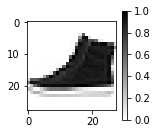

In [54]:
display_image(images[0])

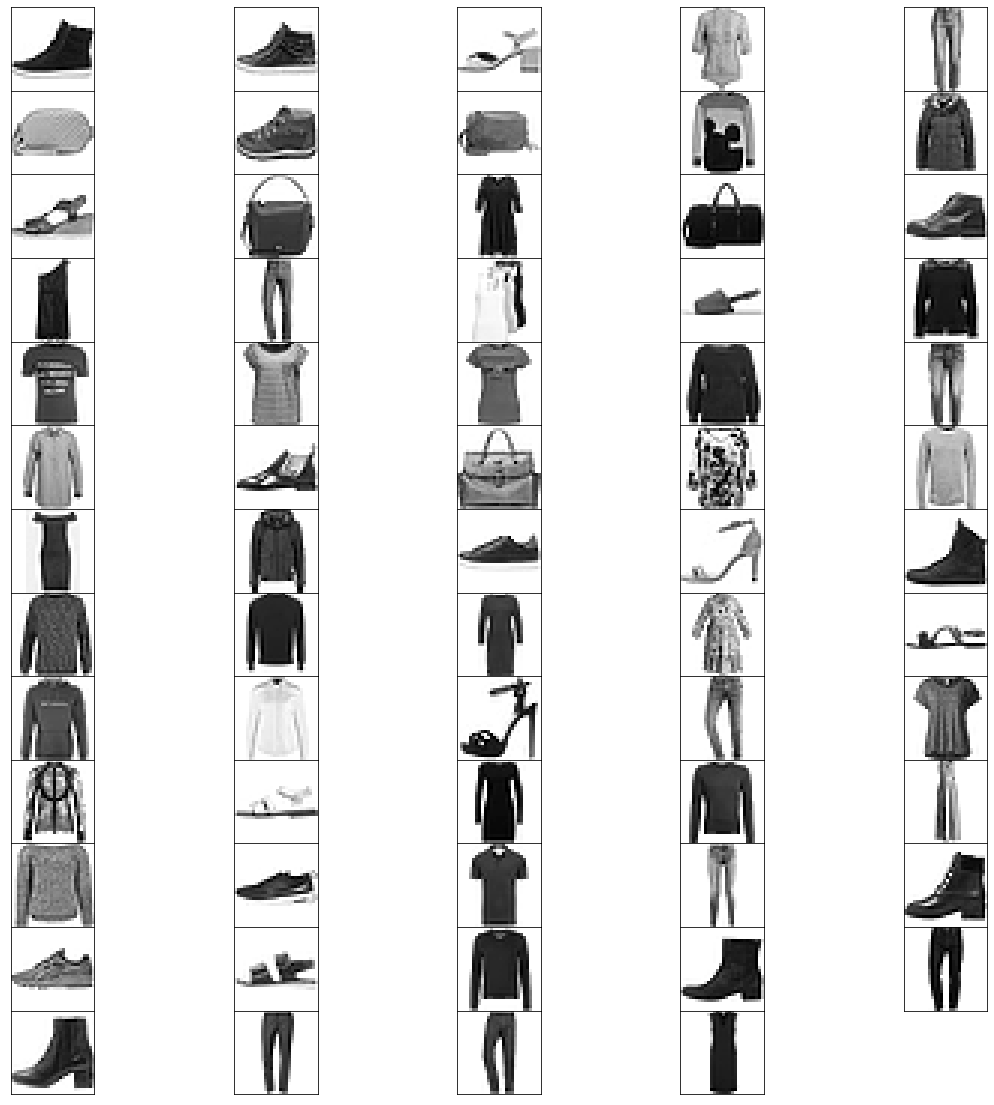

In [68]:
def display_images(images):
    plt.figure(figsize=(20,20))

    i = 0
    for image in images:
        image = image.numpy().reshape((28,28))
        plt.subplot(np.ceil(len(images)/5),5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)
        i += 1
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
display_images(images)

In [61]:
latent_dim = 10

In [89]:
class ConvAutoEncoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(ConvAutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(name='encoder',
            layers = [
              tf.keras.layers.InputLayer(input_shape=(28, 28, 1), name='encoder/input'),
              tf.keras.layers.Conv2D(
                  filters=32, 
                  kernel_size=3, 
                  strides=(2, 2), 
                  padding='same', 
                  activation='relu', 
                  name='encoder/conv1'),
              tf.keras.layers.Conv2D(
                  filters=64, 
                  kernel_size=3, 
                  strides=(2, 2), 
                  padding='same', 
                  activation='relu', 
                  name='encoder/conv2'),
              tf.keras.layers.Flatten(name='encoder/flatten'),
              tf.keras.layers.Dense(latent_dim, name='encoder/bottleneck'),]
        )
        
        self.decoder = tf.keras.Sequential([
          tf.keras.layers.InputLayer(input_shape=(latent_dim), name='decoder/input'),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu, name='decoder/dense1'),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32), name='decoder/reshape'),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding='same',
              activation='relu',
              name='decoder/deconv1'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding='same',
              activation='relu',
              name='decoder/deconv2'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, 
              kernel_size=3, 
              strides=(1, 1), 
              padding='same', 
              name='decoder/deconv3'),])

    def call(self, inputs):
        z = self.encoder(inputs)
        x = self.decoder(z)
        return x
        
    def encode(self, x):
        z = self.encoder(x)
        return z

    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def loss(self, x, y):
        return tf.keras.losses.MeanSquaredError(x, x)

In [91]:
model = ConvAutoEncoder(latent_dim=50)

In [105]:
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy)

In [109]:
n_epochs = 5
model.fit(train_dataset, train_dataset, epochs=n_epochs, steps_per_epoch=np.ceil(num_train_examples/BATCH_SIZE))

ValueError: You passed a dataset or dataset iterator (<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>) as input `x` to your model. In that case, you should not specify a target (`y`) argument, since the dataset or dataset iterator generates both input data and target data. Received: <BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>